In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlscorecheck.auc import (
    integrate_roc_curve, 
    auc_min, 
    auc_max, 
    p_norm_fit_auc, 
    roc_min, 
    roc_max, 
    auc_rmin, 
    auc_maxa, 
    roc_maxa, 
    auc_rmin, 
    roc_rmin, 
    roc_maxa2, 
    auc_maxa2, 
    p_norm_fit,
    p_norm_fit_joint,
    auc_estimator,
    max_acc_estimator)

from sklearn.metrics import r2_score

from scipy.stats import beta, binom
from scipy.optimize import minimize_scalar, root_scalar

In [15]:
input_label = 'single'

input_file = f'fit-{input_label}-50k.csv'
output_file = f'processed-{input_label}-50k.csv'

In [16]:
data = pd.read_csv(input_file)
data[['exp_tpr', 'exp_fpr']].median()

exp_tpr    1.780842
exp_fpr    0.605886
dtype: float64

In [17]:
def protect(function, args):
    try:
        return function(*args)
    except:
        return None

In [18]:
data['auc_min'] = data.apply(lambda row: auc_min(1 - row['spec'], row['sens']), axis=1)
data['auc_min_best'] = data.apply(lambda row: auc_min(1 - row['best_spec'], row['best_sens']), axis=1)
data['auc_max'] = data.apply(lambda row: auc_max(1 - row['spec'], row['sens']), axis=1)
data['auc_max_best'] = data.apply(lambda row: auc_max(1 - row['best_spec'], row['best_sens']), axis=1)
data['auc_maxa_best'] = data.apply(lambda row: protect(auc_maxa, (row['best_acc'], row['p'], row['n'])), axis=1)
data['auc_maxa2_best'] = data.apply(lambda row: protect(auc_maxa2, (row['best_acc'], row['p'], row['n'])), axis=1)
data['auc_rmin_best'] = data.apply(lambda row: protect(auc_rmin, (1 - row['best_spec'], row['best_sens'])), axis=1)
data['auc_rmin'] = data.apply(lambda row: protect(auc_rmin, (1 - row['spec'], row['sens'])), axis=1)

In [19]:
_, x0, y0 = auc_estimator(0.024, 0.776, 30000, 300000, mode='separate', return_details=True, best=False)
_, x1, y1 = auc_estimator(0.024, 0.776, 30000, 300000, mode='joint', return_details=True, best=False)
_, x2, y2 = auc_estimator(0.024, 0.776, 30000, 300000, mode='roc', return_details=True, best=False)

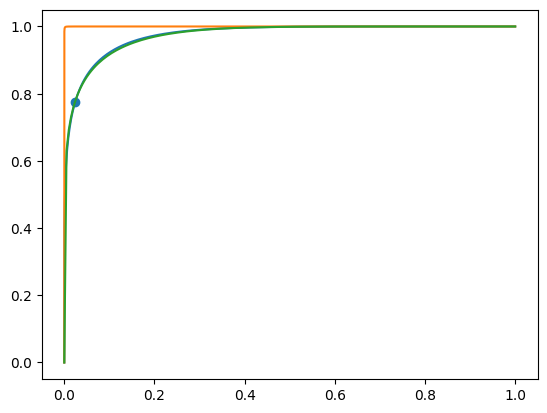

In [20]:
plt.plot(x0, y0)
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.scatter([0.024], [0.776])

In [21]:
(auc_estimator(0.024, 0.776, 30000, 300000, mode='separate', best=True),
auc_estimator(0.024, 0.776, 30000, 300000, mode='joint', best=True),
auc_estimator(0.024, 0.776, 30000, 300000, mode='roc', best=True))

(0.9741123400395921, 0.9892126094609782, 0.9719590818924887)

In [22]:
p = 7.2
x = np.array([0.0, 1.0 - 0.976, 1.0])
y = np.array([0.0, 0.776, 1.0])
np.mean(np.abs((1 - x)**p + y**p - 1))

np.float64(0.00020032072730817121)

In [23]:
data['auc_integral'] = data.apply(lambda row: auc_estimator(1.0 - row['spec'], row['sens'], row['p'], row['n'], mode='separate', best=False), axis=1)
data['auc_integral_best'] = data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='separate', best=True), axis=1)

In [24]:
data['auc_integral3'] = data.apply(lambda row: auc_estimator(1.0 - row['spec'], row['sens'], row['p'], row['n'], mode='joint', best=False), axis=1)
data['auc_integral3_best'] = data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='joint', best=True), axis=1)

In [25]:
data['auc_integral4'] = data.apply(lambda row: auc_estimator(1.0 - row['spec'], row['sens'], row['p'], row['n'], mode='roc', best=False), axis=1)
data['auc_integral4_best'] = data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='roc', best=True), axis=1)

In [26]:
row = data.iloc[0]
max_acc_estimator(row['auc'], row['p'], row['n']), row['best_acc']

(np.float64(0.713047352900976), np.float64(0.7681159420289855))

In [27]:
data['max_acc_integral'] = data.apply(lambda row: max_acc_estimator(row['auc'], row['p'], row['n']), axis=1)

In [28]:
from mlscorecheck.auc import macc_min, acc_max

In [29]:
data['max_acc_min'] = data.apply(lambda row: macc_min(row['auc'], row['p'], row['n']), axis=1)
data['max_acc_max'] = data.apply(lambda row: acc_max(row['auc'], row['p'], row['n']), axis=1)

/home/gykovacs/workspaces/mlscorecheck/mlscorecheck/auc/_acc_single.py:182: RuntimeWarning: invalid value encountered in sqrt
  return 1 - (np.sqrt(2 * p * n - 2 * auc * p * n)) / (p + n)


In [30]:
tmp = data[['best_acc', 'max_acc_min', 'max_acc_max', 'max_acc_integral']].dropna()

In [31]:
r2_score(tmp['best_acc'], (tmp['max_acc_min'] + tmp['max_acc_max'])/2.0)

0.8727635757234633

In [32]:
r2_score(data['best_acc'], data['max_acc_integral'])

0.8926588402930946

In [33]:
r2_score(tmp['best_acc'], ((tmp['max_acc_min'] + tmp['max_acc_max'])/2.0 + tmp['max_acc_integral'])/2.0)

0.936464671621682

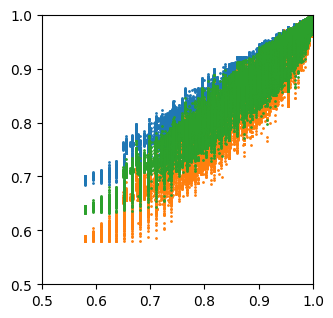

In [34]:
plt.figure(figsize=(3.5, 3.5))
plt.xlim((0.5, 1.0))
plt.ylim((0.5, 1.0))
plt.scatter(tmp['best_acc'], (tmp['max_acc_min'] + tmp['max_acc_max'])/2.0, s=1)
plt.scatter(data['best_acc'], data['max_acc_integral'], s=1)
plt.scatter(tmp['best_acc'], ((tmp['max_acc_min'] + tmp['max_acc_max'])/2.0 + tmp['max_acc_integral'])/2.0, s=1)

In [35]:
data.to_csv(output_file, index=False)

In [36]:
data.iloc[0]

dataset                                                            bupa
classifier                                       RandomForestClassifier
classifier_params                  {'max_depth': 55, 'random_state': 5}
p                                                                    40
n                                                                    29
p_train                                                             160
n_train                                                             116
auc                                                            0.781466
auc_train                                                           1.0
fprs                  [0.0, 0.0, 0.06896551724137931, 0.068965517241...
tprs                  [0.0, 0.05, 0.05, 0.125, 0.125, 0.45, 0.45, 0....
thresholds            [inf, 0.95, 0.9, 0.84, 0.83, 0.76, 0.74, 0.73,...
n_nodes                                                              24
fprs_train                                              [0.0, 0.

In [37]:
data['r2_sum'] = data['r2_min'] + data['r2_max']
data['r2_min'] = data['r2_min'] / data['r2_sum']
data['r2_max'] = data['r2_max'] / data['r2_sum']

data['r2_sum_best'] = data['r2_min_best'] + data['r2_max_best']
data['r2_min_best'] = data['r2_min_best'] / data['r2_sum_best']
data['r2_max_best'] = data['r2_max_best'] / data['r2_sum_best']

KeyError: 'r2_min'

In [ ]:
data['auc_min_max'] = (data['auc_min'] + data['auc_max'])/2.0
data['auc_min_max_best'] = (data['auc_min_best'] + data['auc_max_best'])/2.0
#data['auc_min_maxa_best'] = (data['auc_min_best'] + data['auc_maxa_best'])/2.0
data['auc_min_maxa_best'] = (data['auc_min_best'] * data['r2_max_best'] + data['auc_max_best'] * data['r2_min_best'])
data['auc_min_max_weighted'] = (data['r2_min'] * data['auc_max'] + data['r2_max'] * data['auc_min'])
data['auc_min_maxa_best_weighted'] = (data['r2_min_best'] * data['auc_maxa_best'] + data['r2_maxa_best'] * data['auc_min_best'])


In [ ]:
idx = 1500
row = data.iloc[idx]
row[['r2_min', 'r2_max', 'r2_sum', 'auc_min', 'auc_max', 'auc', 'auc_min_max', 'auc_min_max_weighted', 'n_nodes']]

r2_min                  0.650614
r2_max                  0.349386
r2_sum                       1.0
auc_min                 0.416379
auc_max                 0.882759
auc                     0.759914
auc_min_max             0.649569
auc_min_max_weighted    0.719812
n_nodes                       25
Name: 13215, dtype: object

In [ ]:
row[['auc', 'auc_min_best', 'auc_maxa_best', 'r2_min_best', 'r2_maxa_best', 'auc_min_maxa_best_weighted']]

auc                           0.759914
auc_min_best                  0.524138
auc_maxa_best                 0.903017
r2_min_best                   0.899821
r2_maxa_best                  0.232364
auc_min_maxa_best_weighted    0.934345
Name: 13215, dtype: object

(0.8690299382903445, 0.9216840567591656)

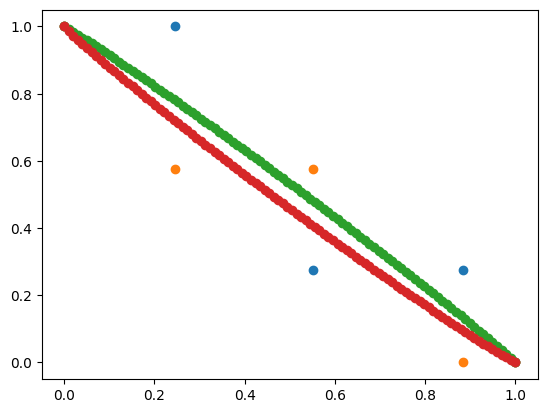

In [ ]:
fprs, tprs = roc_min(1.0 - row['spec'], row['sens'])
fracs = 1.0 - (row['p']*tprs + row['n']*fprs)/(row['p'] + row['n'])
p = exponential_fit(fracs, fprs)
p_tpr = exponential_fit(fracs, tprs)
x = np.linspace(0, 1, 100)
plt.scatter(fracs, fprs)
plt.scatter(fracs, tprs)
plt.scatter(x, ((1.0 - x**p)**(1.0/p)))
plt.scatter(x, ((1.0 - x**p_tpr)**(1.0/p_tpr)))
(r2_score(fprs, ((1.0 - fracs**p)**(1.0/p))),
r2_score(tprs, ((1.0 - fracs**p_tpr)**(1.0/p_tpr))))

In [ ]:
row['fprs'], row['tprs'], row['spec'], row['sens']

('[0.0, 0.0, 0.034482758620689655, 0.06896551724137931, 0.13793103448275862, 0.13793103448275862, 0.20689655172413793, 0.20689655172413793, 0.2413793103448276, 0.2413793103448276, 0.27586206896551724, 0.27586206896551724, 0.3103448275862069, 0.3103448275862069, 0.3448275862068966, 0.3448275862068966, 0.41379310344827586, 0.41379310344827586, 0.4482758620689655, 0.4482758620689655, 0.6206896551724138, 0.6206896551724138, 0.7931034482758621, 0.8275862068965517, 1.0]',
 '[0.0, 0.225, 0.225, 0.25, 0.25, 0.3, 0.3, 0.45, 0.45, 0.55, 0.575, 0.65, 0.675, 0.7, 0.7, 0.8, 0.8, 0.875, 0.9, 0.95, 0.95, 0.975, 0.975, 1.0, 1.0]',
 np.float64(0.7241379310344828),
 np.float64(0.575))

In [ ]:
fprs = np.array([0.0, 1.0 - row['spec'], 1.0])
tprs = np.array([0.0, row['sens'], 1.0])
fracs = 1.0 - (row['p']*tprs + row['n']*fprs)/(row['p'] + row['n'])

p_fpr = exponential_fit(fracs, fprs)
p_tpr = exponential_fit(fracs, tprs)

(0.7731380223583438, 1.206160775482911)

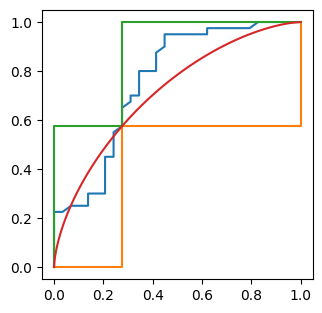

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(eval(row['fprs']), eval(row['tprs']))
plt.plot(*roc_min(1.0 - row['spec'], row['sens']))
plt.plot(*roc_max(1.0 - row['spec'], row['sens']))
plt.plot(((1.0 - x**p_fpr)**(1.0/p_fpr)), ((1.0 - x**p_tpr)**(1.0/p_tpr)))
p_fpr, p_tpr

In [ ]:
tmp = data[data['n_nodes'] > 3]

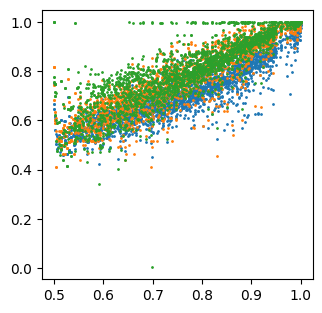

In [ ]:
plt.figure(figsize=(3.5, 3.5))
#plt.xlim((0.5, 1))
#plt.ylim((0.5, 1))
plt.scatter(tmp['auc'], tmp['auc_min_max'], s=1)
plt.scatter(tmp['auc'], tmp['auc_min_max_weighted'], s=1)
plt.scatter(tmp['auc'], tmp['auc_integral'], s=1)

In [ ]:
r2_score(tmp['auc'], tmp['auc_min_max']), r2_score(tmp['auc'], tmp['auc_min_max_weighted']), r2_score(tmp['auc'], tmp['auc_integral'])

(0.6464459659423477, 0.8033864568145052, 0.6298287243049956)

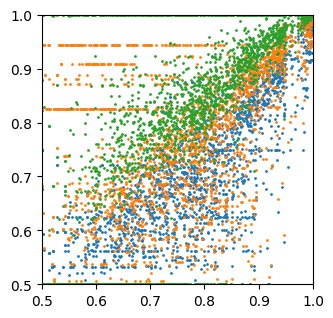

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.xlim((0.5, 1))
plt.ylim((0.5, 1))
plt.scatter(tmp['auc'], tmp['auc_min_max_best'], s=1)
#plt.scatter(tmp['auc'], tmp['auc_min_maxa_best'], s=1)
plt.scatter(tmp['auc'], tmp['auc_min_maxa_best_weighted'], s=1)
plt.scatter(tmp['auc'], tmp['auc_integral_best'], s=1)

In [ ]:
tmp2 = tmp[['auc', 'auc_min_max_best', 'auc_min_maxa_best', 'auc_min_maxa_best_weighted', 'auc_integral_best']].dropna()

In [ ]:
r2_score(tmp2['auc'], tmp2['auc_min_max_best']), r2_score(tmp2['auc'], tmp2['auc_min_maxa_best']), r2_score(tmp2['auc'], tmp2['auc_min_maxa_best_weighted'])

(0.25937737096156743, -0.1315558311072753, -0.19677445407509464)

In [ ]:
def fit_curve(row, values, fracs):
    if values == 'fprs':
        values = row[values]
        fracs = row[fracs]
        p = np.logspace(-2, 0, 3000)
    else:
        values = row[values]
        fracs = row[fracs]
        p = np.logspace(0, 2, 3000)
    
    err = np.abs(values[:, None]**p - 1 + (1 - fracs)[:, None]**p)
    err = np.mean(err, axis=0)
    exp = p[np.argmin(err)]

    pred = (1 - (1 - fracs)**exp)**(1/exp)

    if len(values) < 2:
        return (1, exp, 0)

    r2 = r2_score(values, pred)

    return (r2, exp, 0)

In [ ]:
def auc_est6(sens, spec):
    p = np.logspace(-3, 3, 3000)
    
    err = np.abs(sens**p - 1 + spec**p)
    exp = p[np.argmin(err)]

    x = np.linspace(0, 1, 1000)
    y = (1 - (1 - x)**exp)**(1/exp)
    
    return np.sum((y[1:] + y[:-1])/2*(x[1:] - x[:-1]))

In [ ]:
def auc_est5(sens, spec, p, n):
    spec = max(min(spec, 0.999), 0.001)
    sens = max(min(sens, 0.999), 0.001)
    frac = (sens*p + (1 - spec)*n)/(p + n)
    exp_tpr = fit_curve({'tprs': np.array([sens]), 'fracs': np.array([frac])}, 'tprs', 'fracs')[1]
    exp_fpr = fit_curve({'fprs': np.array([1 - spec]), 'fracs': np.array([frac])}, 'fprs', 'fracs')[1]

    x = np.linspace(0, 1, 1000)
    fprs = (1 - (1 - x)**exp_fpr)**(1/exp_fpr)
    tprs = (1 - (1 - x)**exp_tpr)**(1/exp_tpr)

    return np.sum((tprs[1:] + tprs[:-1])/2*(fprs[1:] - fprs[:-1]))

In [ ]:
"""def auc_est6(row):
    return row['exp_fpr'] / (row['exp_fpr'] + row['exp_tpr'])"""

"def auc_est6(row):\n    return row['exp_fpr'] / (row['exp_fpr'] + row['exp_tpr'])"

In [ ]:
#data = data[(data['sens'] > 0) & (data['sens'] < 1) & (data['spec'] > 0) & (data['spec'] < 1)]

In [ ]:
data['min_class'] = data.apply(lambda row: min(row['p'], row['n']), axis=1)

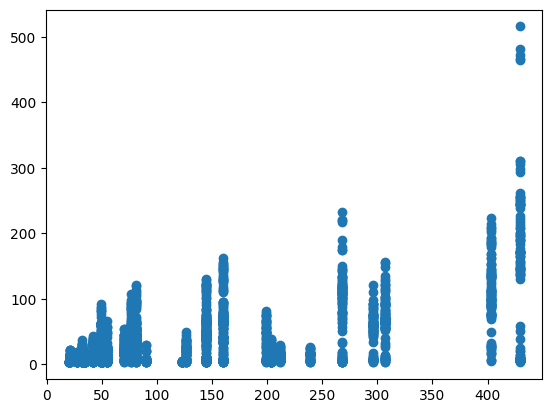

In [ ]:
plt.scatter(data['min_class'], data['n_nodes'])

In [ ]:
#data = data[data.apply(lambda row: min(row['p'], row['n']), axis=1) > 40]

In [ ]:
data['auc_est5'] = data.apply(lambda row: auc_est5(row['sens'], row['spec'], row['p'], row['n']), axis=1)

data['auc_min_max'] = (data['sens'] + data['spec'])/2.0

In [ ]:
data['auc_est6'] = data.apply(lambda row: auc_est6(row['sens'], row['spec']), axis=1)

In [ ]:
def auc_composite(row):
    auc_upper = row['auc_est5']
    auc_lower = row['auc_min_max']
    weight = row['n_nodes']
    weight_upper = weight**2
    weight_lower = max(25 - weight, 0)**2
    weight_sum = weight_lower + weight_upper
    weight_upper = weight_upper / weight_sum
    weight_lower = weight_lower / weight_sum

    return auc_upper * weight_upper + auc_lower * weight_lower

data['auc_comp'] = data.apply(auc_composite, axis=1)

In [ ]:
#data = data[data['classifier'] != 'DecisionTreeClassifier']

In [ ]:
#data = data[data['n_nodes'] > 20]

In [ ]:
#data = data[(data['sens'] > 0) & (data['sens'] < 1) & (data['spec'] > 0) & (data['spec'] < 1)]

In [ ]:
r2_score(data['auc'], data['auc_est5']), r2_score(data['auc'], data['auc_min_max']), r2_score(data['auc'], data['auc_comp']), r2_score(data['auc'], data['auc_est6'])

(0.8003842662327819,
 0.839017739487883,
 0.958715476443063,
 -0.21635288511704487)

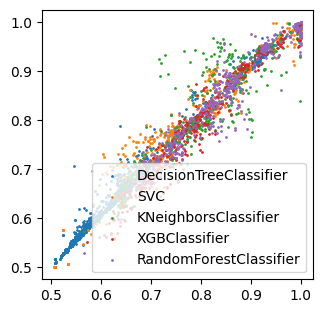

In [ ]:
plt.figure(figsize=(3.5, 3.5))
for classifier in data['classifier'].drop_duplicates():
    tmp = data[data['classifier'] == classifier]
    plt.scatter(tmp['auc'], tmp['auc_comp'], s=1, label=classifier)
plt.legend()

In [ ]:
auc_est5(0.776, 0.978, 30000, 300000)

np.float64(0.9763938791759392)

In [ ]:
def auc_est5_stats(sens, spec, p, n):
    aucs = []
    for _ in range(100000):
        sens_samp = beta.rvs(b=p-sens*p+1, a=sens*p)
        spec_samp = beta.rvs(b=n-spec*n+1, a=spec*n)
        p_samp = binom.rvs(p, sens_samp)
        n_samp = binom.rvs(n, spec_samp)

        aucs.append(auc_est5(p_samp/p, n_samp/n, p, n))
    return aucs

In [ ]:
tmp = data.sample(10, random_state=5)

In [ ]:
tmp[['sens', 'spec']]

,sens,spec
18364,0.957977,0.960859
6235,0.918968,0.934199
9606,0.977767,0.943750
11594,0.897569,0.631944
8302,0.779804,0.708000
10399,0.631250,0.705082
18476,0.724973,0.668750
8043,0.878641,0.954955
7577,0.750167,0.690236
7129,0.619307,0.713138


In [ ]:
tmp['aucs'] = tmp.apply(lambda row: auc_est5_stats(row['sens'], row['spec'], row['p'], row['n']), axis=1)

KeyboardInterrupt: 

((array([419.,  95.,  82.,  82.,  89.,  82.,  59.,  42.,  38.,  12.]),
  array([0.5       , 0.53959259, 0.57918518, 0.61877777, 0.65837037,
         0.69796296, 0.73755555, 0.77714814, 0.81674073, 0.85633332,
         0.89592592]),
  <BarContainer object of 10 artists>),
 np.float64(0.7333333333333333),
 np.float64(0.6546049467138704))

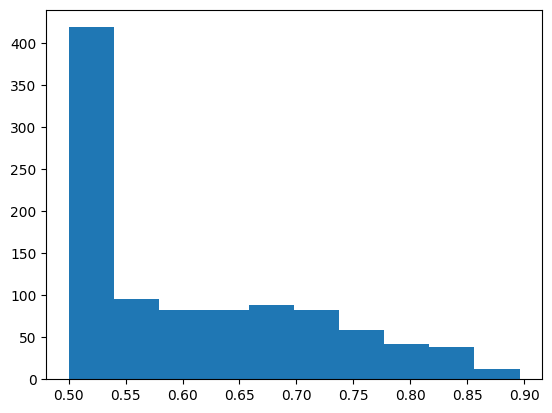

In [ ]:
row = tmp.iloc[6]
plt.hist(row['aucs']), row['auc'], row['auc_est5']

In [ ]:
aucs = auc_est5_stats(0.7763, 0.9768, 20_000, 200_000)

((array([5.9000e+01, 6.8600e+02, 4.4330e+03, 1.4509e+04, 3.0116e+04,
         2.9231e+04, 1.6381e+04, 4.0490e+03, 5.1300e+02, 2.3000e+01]),
  array([0.97267136, 0.9732576 , 0.97384383, 0.97443006, 0.97501629,
         0.97560253, 0.97618876, 0.97677499, 0.97736122, 0.97794746,
         0.97853369]),
  <BarContainer object of 10 artists>),
 np.float64(0.9726713642682261))

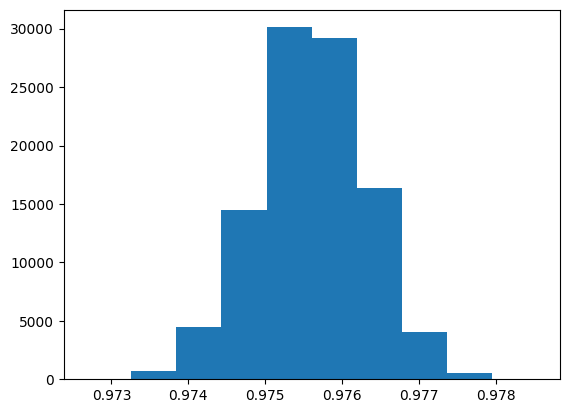

In [ ]:
plt.hist(aucs), min(aucs)

In [ ]:
row = data[(data['auc'] < 0.8) & (data['auc_est5'] > 0.99)].iloc[2]

IndexError: single positional indexer is out-of-bounds

In [ ]:
row

dataset                                                   appendicitis
classifier                                                         SVC
classifier_params    {'probability': True, 'C': 0.10549567054834408...
p                                                                    4
n                                                                   18
p_train                                                             17
n_train                                                             67
auc                                                           0.763889
auc_train                                                     0.852502
fprs                 [0.0, 0.0, 0.9444444444444444, 0.9444444444444...
tprs                                       [0.0, 0.75, 0.75, 1.0, 1.0]
thresholds           [inf, 0.3377494314457134, 0.08287531095442542,...
n_nodes                                                              5
fprs_train           [0.0, 0.0, 0.014925373134328358, 0.01492537313...
tprs_t

In [ ]:
def auc_est5(sens, spec, p, n):
    frac = (sens*p + (1 - spec)*n)/(p + n)
    exp_tpr = fit_curve({'tprs': np.array([sens]), 'fracs': np.array([frac])}, 'tprs', 'fracs')[1]
    exp_fpr = fit_curve({'fprs': np.array([1 - spec]), 'fracs': np.array([frac])}, 'fprs', 'fracs')[1]

    print(exp_tpr, exp_fpr)

    x = np.linspace(0, 1, 10000)
    fprs = (1 - (1 - x)**exp_fpr)**(1/exp_fpr)
    tprs = (1 - (1 - x)**exp_tpr)**(1/exp_tpr)

    plt.plot(fprs, tprs)
    plt.plot(x, fprs)
    plt.plot(x, tprs)

    print(fprs, tprs)

    return np.sum((tprs[1:] + tprs[:-1])/2*(fprs[1:] - fprs[:-1]))

3.3177241960960204 0.01
[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.55884352e-109
 2.76992055e-106 1.00000000e+000] [0.         0.08940039 0.11016867 ... 1.         1.         1.        ]


np.float64(0.9999999999999919)

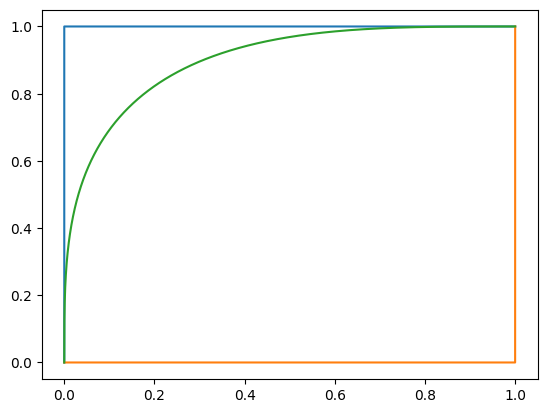

In [ ]:
auc_est5(row['sens'], row['spec'], row['p'], row['n'])

In [ ]:
def auc_est4(row):

    p = row['p']
    n = row['n']

    th = p/(p + n)

    tpr = row['sens']
    fpr = 1 - row['spec']

    alpha = max(0, np.log(1 - tpr)/ np.log(th))
    beta = max(0, np.log(fpr)/np.log(1 - th))

    print(alpha, beta)

    tprs = 1 - np.linspace(0, 1, 2000)**alpha
    fprs = (1 - np.linspace(0, 1, 2000))**beta

    return np.sum((tprs[1:] + tprs[:-1])/2 * (fprs[:-1] - fprs[1:]))

In [ ]:
tmp2[['auc', 'auc_est4', 'sens', 'spec', 'p', 'n', 'n_nodes']]

KeyError: "['auc_est4'] not in index"

In [ ]:
auc_est4(data.iloc[19999])

1 6.383263099338103


np.float64(0.8645583979077229)

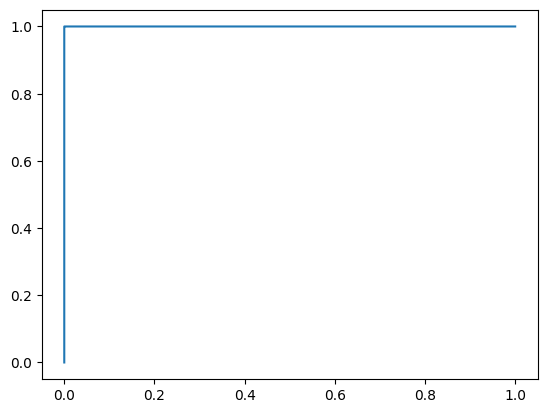

In [ ]:
plt.plot(fprs, tprs)

In [ ]:
tmp = data[(data['sens'] > 0) & (data['sens'] < 1) & (data['spec'] > 0) & (data['spec'] < 1)].sample(20)

In [ ]:
tmp['auc_est3'] = tmp.apply(lambda row: auc_est3(row['spec'], row['sens'], row['p'], row['n']), axis=1)

0.5038167938931297 0.45038167938931295 2.2887054167495595 2.460921578846517 59 72 6.092286952696924e-08 0.8388804247851294 0.8813559322033898 0.22925087386907328 0.19444444444444442
0.5481927710843374 0.4879518072289157 6.133338360122559 3.0557743442915037 81 85 2.7150456327618144e-09 0.987733793378303 0.8641975308641975 0.12933602689011645 0.24705882352941178
0.3376623376623376 0.35064935064935066 2.6736636812950803 10.098364971651748 54 100 3.4541369764440333e-09 0.9393063055524823 0.6111111111111112 0.012774600321030468 0.18999999999999995
0.3064516129032258 0.25806451612903225 2.777223955699531 8.754584902464511 16 46 1.0321265397905677e-08 0.9767599144030501 0.5 0.07330091324934027 0.23913043478260865
0.572289156626506 0.4879518072289157 3.0663495109125387 1.9546669424687464 81 85 3.3571593394121635e-08 0.8892216851815073 0.8518518518518519 0.2702710344401577 0.3058823529411765
0.5915492957746479 0.647887323943662 4.09876636139165 1.8136966095989817 46 25 3.597732800564302e-08 0.8

In [ ]:
tmp[['auc', 'auc_est3']]

,auc,auc_est3
18549,0.924788,0.892745
11156,0.867901,0.989294
10920,0.710556,0.994631
19394,0.730978,0.993539
2191,0.837981,0.899333
16046,0.981739,0.922677
5161,0.993386,0.992180
7794,0.820000,0.999928
10307,0.711066,0.945325
8183,0.620690,0.898618


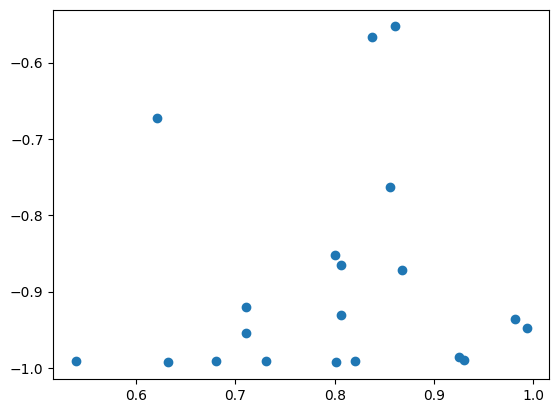

In [ ]:
plt.scatter(tmp['auc'], tmp['auc_est3'])

In [ ]:
r2_score(tmp['auc'], tmp['auc_est2'])

0.45497661734405814

In [ ]:
if equalized:
    n_samples = 300

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data = pd.concat(tmp)

In [ ]:
data['tprs'] = data['tprs'].apply(lambda x: np.array(eval(x)))
data['fprs'] = data['fprs'].apply(lambda x: np.array(eval(x)))
data['fracs'] = data['fracs'].apply(lambda x: np.array(eval(x)))
data['frac'] = (data['sens']*data['p'] + (1 - data['spec'])*data['n'])/(data['p'] + data['n'])

In [ ]:
def fit_p3(sens, frac):
    tpr = sens

    p = np.logspace(-2, 2, 10000)
    etpr = np.abs(frac**p - tpr) / tpr + np.abs((1 - frac)**(1/p) - (1 - tpr))/(1 - tpr)

    idx = np.argmin(etpr)
    return p[idx]

In [ ]:
def auc_est(sens, spec, frac):
    p0 = fit_p3(sens, frac)
    p1 = 1.0/fit_p3(spec, 1-frac)

    return p1/(p0 + p1)

In [ ]:
data.head()

,dataset,classifier,classifier_params,p,n,p_train,n_train,auc,auc_train,fprs,...,best_sens_train,best_spec_train,fracs,r2_fpr,exp_fpr,fit_mode_fpr,r2_tpr,exp_tpr,fit_mode_tpr,frac
9333,abalone9_18,DecisionTreeClassifier,"{'max_depth': 116, 'random_state': 5}",8,139,34,550,0.526529,1.000000,"[0.0, 0.07194244604316546, 1.0]",...,1.000000,1.000000,"[0.0, 0.07482993197278912, 1.0]",1.000000,1.015179,-1,1.000000,0.582468,-3,0.074830
18298,appendicitis,XGBClassifier,"{'random_state': 5, 'max_depth': 3}",18,4,67,17,0.527778,0.997366,"[0.0, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 1.0]",...,0.985075,1.000000,"[0.0, 0.045454545454545456, 0.3181818181818182...",0.410385,0.570687,-1,0.988386,0.937009,-3,0.772727
11554,saheart,DecisionTreeClassifier,"{'max_depth': 73, 'random_state': 5}",61,32,241,128,0.539959,1.000000,"[0.0, 0.625, 1.0]",...,1.000000,1.000000,"[0.0, 0.6774193548387096, 1.0]",1.000000,1.206794,-1,1.000000,0.926997,-3,0.677419
13791,saheart,DecisionTreeClassifier,"{'max_depth': 18, 'random_state': 5}",32,61,128,241,0.524334,1.000000,"[0.0, 0.29508196721311475, 1.0]",...,1.000000,1.000000,"[0.0, 0.3118279569892473, 1.0]",1.000000,1.047368,-1,1.000000,0.887238,-3,0.311828
7159,CM1,SVC,"{'probability': True, 'C': 0.3716572355638991,...",90,10,359,39,0.513333,0.881830,"[0.0, 0.0, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.7, ...",...,0.963788,0.794872,"[0.0, 0.08, 0.11, 0.13, 0.14, 0.54, 0.55, 0.77...",0.623334,0.599823,-1,0.996598,0.992561,-3,0.900000


In [ ]:
data['auc_est2'] = data['exp_fpr'] / (data['exp_fpr'] + data['exp_tpr'])

In [ ]:
data.columns

Index(['dataset', 'classifier', 'classifier_params', 'p', 'n', 'p_train',
       'n_train', 'auc', 'auc_train', 'fprs', 'tprs', 'thresholds', 'n_nodes',
       'fprs_train', 'tprs_train', 'thresholds_train', 'n_nodes_train', 'acc',
       'sens', 'spec', 'best_acc', 'best_sens', 'best_spec', 'acc_train',
       'sens_train', 'spec_train', 'best_acc_train', 'best_sens_train',
       'best_spec_train', 'fracs', 'r2_fpr', 'exp_fpr', 'fit_mode_fpr',
       'r2_tpr', 'exp_tpr', 'fit_mode_tpr', 'frac', 'auc_est2'],
      dtype='object')

In [ ]:
data['auc_est'] = data.apply(lambda row: auc_est(row['sens'], row['spec'], row['frac']), axis=1)

/tmp/ipykernel_3311169/2336068737.py:5: RuntimeWarning: divide by zero encountered in divide
  etpr = np.abs(frac**p - tpr) / tpr + np.abs((1 - frac)**(1/p) - (1 - tpr))/(1 - tpr)


0.8131877917941088

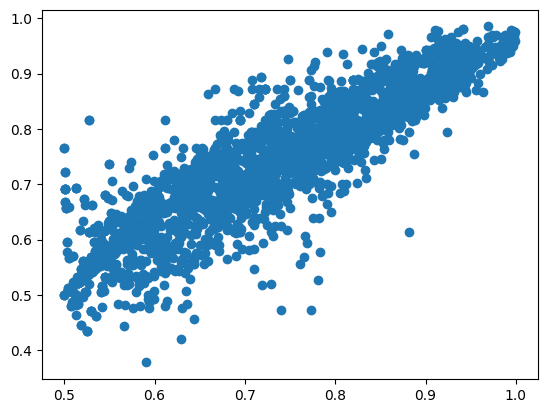

In [ ]:
tmp = data[(data['sens'] > 0) & (data['sens'] < 1) &(data['spec'] > 0) & (data['spec'] < 1)].dropna()
plt.scatter(tmp['auc'], tmp['auc_est'])
r2_score(tmp['auc'], tmp['auc_est'])

In [ ]:
auc_est(0.776, 0.9768, 0.07)

np.float64(0.9668847398440344)

In [ ]:
fit_p3(0.776, 0.08)

np.float64(0.05572814761090012)

In [ ]:
fit_p3(1 - 0.9768, 0.08)

np.float64(1.4907929892623273)

In [ ]:
1.49/(1.49 + 0.055)

0.964401294498382

In [ ]:
def fit_p1(spec, sens, frac, mode_tpr=0, mode_fpr=0):
    tpr = sens
    fpr = 1 - spec

    p = np.logspace(-2, 0, 10000)
    if mode_tpr == 0:
        etpr = np.abs(frac**p - tpr) / tpr
    else:
        etpr = np.abs((1 - frac)**(1/p) - (1 - tpr))/(1 - tpr)

    if mode_fpr == 0:
        efpr = np.abs(frac**(1/p) - fpr) / fpr
    else:
        efpr = np.abs((1 - frac)**(p) - (1 - fpr))/(1 - fpr)

    idx = np.argmin(etpr + efpr)
    print(etpr[idx], efpr[idx])
    return p[idx]

In [ ]:
(fit_p1(0.9768, 0.776, 0.08, 0, 0),
 fit_p1(0.9768, 0.776, 0.08, 1, 0),
 fit_p1(0.9768, 0.776, 0.08, 0, 1),
 fit_p1(0.9768, 0.776, 0.08, 1, 1))

0.7634027463416212 1.7787864410589995e-06
0.00011148300482790944 1.0
3.9188450620303236e-05 0.015217108071320144
0.00011148300482790944 0.01900499243364162


(np.float64(0.6710929527817348),
 np.float64(0.05572814761090012),
 np.float64(0.10039224589211208),
 np.float64(0.05572814761090012))

In [ ]:
def fit_p2(spec, sens, frac):
    tpr = sens
    fpr = 1 - spec

    p = np.logspace(-2, 2, 10000)
    idx = np.argmin(np.abs((1 - frac)**p - (1 - tpr)) / tpr + np.abs((1 - frac)**(p) - (1 - fpr))/(1 - spec))
    return p[idx]

In [ ]:
p1 = fit_p1(0.9768, 0.776, 0.08)
p2 = fit_p2(0.9768, 0.776, 0.08)
p1, p2

0.7634027463416212 1.7787864410589995e-06


(np.float64(0.6710929527817348), np.float64(0.2814135044524948))

In [ ]:
p1/(p1 + (1/p1)), (p2)/(p2 + (1/p2))

(np.float64(0.31051874389471884), np.float64(0.07338216552404798))

In [ ]:
float(p/(p + (1/p)))

NameError: name 'p' is not defined

In [ ]:
def fit_p(spec, sens):
    x = np.linspace(1, 5, 10000)
    idx = np.argmin(np.abs(spec**x + (1 - sens)**x - 1))
    return x[idx]

In [ ]:
def norm_area(spec, sens):
    p = fit_p(spec, sens)
    x = np.linspace(0, 1, 1000)
    return integrate_roc_curve(x**p, (1 - (1 - x)**p)**(1/p))

In [ ]:
norm_area(0.9768, 0.7763)

0.9109848333984671

In [ ]:
p = fit_p(0.982, 0.77)
p

np.float64(2.2033203320332033)

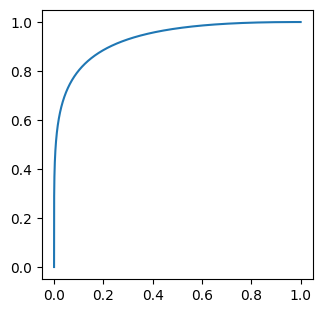

In [ ]:
#p = 3
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(3.5, 3.5))
plt.plot(x**p, (1 - (1 - x)**p)**(1/p))

In [ ]:
fit_p(0.98, 0.77)

np.float64(2.1493149314931497)

In [ ]:
norm_area(0.98, 0.77)

0.9253901055010616

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def exponential_fitting2(row, label, frac_label):

    values = row[label].copy()
    counts = row[frac_label].copy()
    
    mask = values > 1e-6
    values_nz = values[mask]
    counts_nz = counts[mask]

    ln_values = np.log(values_nz)
    ln_counts = np.log(counts_nz)

    values2 = (1 - values)
    counts2 = (1 - counts)

    mask2 = (values2 > 1e-6) & (values2 < 1)
    values2_nz = values2[mask2]
    counts2_nz = counts2[mask2]

    ln_values2 = 1/np.log(values2_nz)
    ln_counts2 = 1/np.log(counts2_nz)

    ln_y = np.hstack([ln_values, ln_values2])
    ln_x = np.hstack([ln_counts, ln_counts2]).reshape(-1, 1)

    print(ln_x, ln_y)

    linreg_a = LinearRegression(fit_intercept=False, positive=True)
    pred_values = linreg_a\
        .fit(ln_x, ln_y)\
        .predict(ln_x)

    r2_a = r2_score(ln_y, pred_values)

    return (r2_a, linreg_a.coef_[0], 0)

In [ ]:
"""row = data.iloc[0]
exponential_fitting(row, 'tprs', 'fracs')"""

"row = data.iloc[0]\nexponential_fitting(row, 'tprs', 'fracs')"

In [ ]:
row

dataset                                                           bupa
classifier                                      RandomForestClassifier
classifier_params                 {'max_depth': 22, 'random_state': 5}
p                                                                   40
n                                                                   29
p_train                                                            160
n_train                                                            116
auc                                                           0.781466
auc_train                                                          1.0
fprs                 [0.0, 0.0, 0.06896551724137931, 0.068965517241...
tprs                 [0.0, 0.05, 0.05, 0.125, 0.125, 0.45, 0.45, 0....
thresholds           [inf, 0.95, 0.9, 0.84, 0.83, 0.76, 0.74, 0.73,...
n_nodes                                                             24
fprs_train                                             [0.0, 0.0, 1.0]
tprs_t

In [ ]:
if equalized:
    n_samples = 300

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data = pd.concat(tmp)

In [ ]:
data.columns

Index(['p', 'n', 'k', 'dataset', 'classifier', 'classifier_params', 'best_acc',
       'best_sens', 'best_spec', 'best_acc_train', 'best_sens_train',
       'best_spec_train', 'acc', 'sens', 'spec', 'auc', 'acc_train',
       'sens_train', 'spec_train', 'auc_train', 'n_nodes', 'n_nodes_train',
       'avg_n_nodes', 'avg_n_nodes_train', 'fprs', 'tprs', 'fprs_train',
       'tprs_train', 'fracs', 'r2_fpr', 'exp_fpr', 'fit_mode_fpr', 'r2_tpr',
       'exp_tpr', 'fit_mode_tpr'],
      dtype='object')

In [ ]:
data['auc_analytic'] = data['exp_fpr'] / (data['exp_fpr'] + data['exp_tpr'])

In [ ]:
data['frac'] = (data['sens'] * data['p'] + (1 - data['spec']) * data['n']) / (data['p'] + data['n'])
data['frac'] = data['frac'].apply(lambda x: np.round(x, 1))

In [ ]:
data['flag'] = (data['p'] / data['n'] < 1.3) & (data['p'] / data['n'] > 0.7)
data['n_nodes'] = data['n_nodes'].apply(lambda x: np.round(x/10, 0)*10)

In [ ]:
data[(data['fit_mode_tpr'] != -1) & (data['p'] < data['n'])].groupby(['fit_mode_tpr']).agg({'p': 'count'}).iloc[:30]

,p
fit_mode_tpr,
0,575
1,871


In [ ]:
data[['p', 'n', 'n_nodes', 'r2_fpr', 'exp_fpr', 'fit_mode_fpr', 'r2_tpr', 'exp_tpr', 'fit_mode_tpr']]

,p,n,n_nodes,r2_fpr,exp_fpr,fit_mode_fpr,r2_tpr,exp_tpr,fit_mode_tpr
16789,81,225,8,0.999835,1.059050,0,0.998477,0.856185,0
4864,49,449,4,0.999549,1.070177,0,0.997862,0.688733,0
18884,225,81,6,0.996687,1.195727,0,0.999438,0.933275,0
2702,225,81,8,0.999691,0.844438,1,0.999951,1.068382,1
16895,49,449,7,0.999822,0.946262,1,0.996732,0.807258,0
...,...,...,...,...,...,...,...,...,...
15871,444,239,17,0.853574,7.886440,0,0.855360,2.960262,1
7498,28,444,9,0.955269,0.557980,1,0.910346,11.178554,1
5666,444,239,17,0.762624,7.471571,0,0.905277,3.025893,1
11136,180,35,3,1.000000,-1.000000,-1,1.000000,-1.000000,-1


In [ ]:
tmp = data[(data['fit_mode_fpr'] == 0) & (data['fit_mode_tpr'] == 0)]

In [ ]:
tmp2 = tmp[tmp['auc_analytic'] >= 0.5]

In [ ]:
r2_score(tmp2['auc'], tmp2['auc_analytic'])

0.8928208790464232

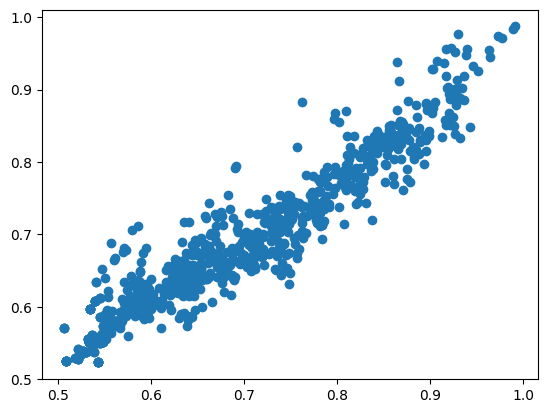

In [ ]:
plt.scatter(tmp2['auc'], tmp2['auc_analytic'])